In [0]:
import torch


In [18]:
#For Kaggle
from google.colab import files
import os
files.upload()
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

Saving kaggle.json to kaggle (1).json


0

In [19]:
!kaggle datasets download -d somnath796/detect-emotions-of-your-favorite-toons

detect-emotions-of-your-favorite-toons.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip /content/detect-emotions-of-your-favorite-toons.zip

In [0]:
#Kaggle
filepath = "/content/frames/train_frames"
file_path_train = "/content/96714c94-6-Dataset/Dataset/Train.csv"

root_dir_train = "/content/frames/train_frames"
file_path_test = "/content/96714c94-6-Dataset/Dataset/Test.csv"
root_dir_test = "/content/frames/test_frames"
#PC
#filepath = "C:\\Users\\ACER\\Desktop\\EmotionDetection\\Dataset\\frames\\train_frames"
#file_path = pd.read_csv('C:\\Users\\ACER\\Desktop\\EmotionDetection\\Dataset\\Train.csv')
#root_dir =  "'C:\\Users\\ACER\\Desktop\\EmotionDetection\\Dataset\\frames\\train_frames"

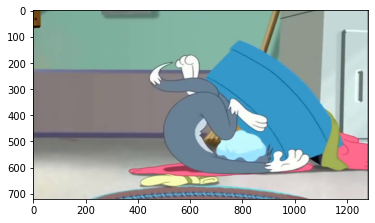

In [6]:
#Testing functionality
from PIL import Image
import matplotlib.pyplot as plt
import os
pathDir = os.listdir(filepath)
j = '7'
image = 'frame'+j+'.jpg'
pathnew = filepath + '/'+ image
img = Image.open(pathnew)
plt.imshow(img)

In [28]:
import pandas as pd
file  = pd.read_csv(file_path_train)
print(file.iloc[1,0], file.iloc[1,1])


frame1.jpg happy


In [0]:
encoder = {
    'happy': 0,
    'surprised' : 1,
    'angry': 2,
    'sad': 3,
    'Unknown': 4

}

In [0]:
decoder = {
    0 : 'happy',
    1 : 'surprised' ,
    2 : 'angry',
    3 : 'sad',
    4 : 'Unknown'

}

In [0]:
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from skimage import io, transform
import pandas as pd
class classDataset(Dataset):
    def __init__(self, csv_file, root_dir, encoder, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.encoder = encoder
        self.transform = transform

    def __len__(self):
        return len(self.images_file)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,
                                self.images_file.iloc[idx, 0])
        image = io.imread(img_name)
        if(self.transform):
            image = self.transform(image)
        label =  self.images_file.iloc[idx, 1]
        return image, self.encoder[label]
        #sample = {'image': image, 'label': label}
       

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

In [0]:

train_files = classDataset(file_path_train, root_dir_train, encoder, train_transforms)
test_files = classDataset(file_path_test, root_dir_test, encoder, train_transforms)
train_loader = DataLoader(train_files, shuffle = True, batch_size = 10)
test_loader = DataLoader(test_files, shuffle = True, batch_size = 10)

In [0]:
from torch import nn
from torchvision import models
class classifie(nn.Module):
    def __init__(self, n_classes, pretrained = True ):
        super(classifie, self).__init__()
        self.cnn_arch = models.resnet18(pretrained = pretrained)
        self.linear1 = nn.Linear(1000,256)
        self.relu = nn.LeakyReLU()
        self.linear2 = nn.Linear(256,n_classes)
        #self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.7)
   
    def forward(self, input):
        am = self.cnn_arch(input)
        x = self.dropout(self.relu(self.linear1(am)))
        x = self.linear2(x)
        return x

In [0]:
model = classifie(6)

In [0]:
import time
import sys

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(model,epoch,data_loader):
    print('Training Epoch {}'.format(epoch))
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracies = AverageMeter()
    start_time = time.time()
    end_time = time.time()
    t = []
    batch_size= 10
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
    for i, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - end_time)
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        outputs = model(inputs)    
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = 100 * (outputs.detach().argmax(1) == targets).cpu().numpy().mean()
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        sys.stdout.write(
                "\r[Epoch %d] [Batch %d / %d] [Time %.2f %.2f] [Data %.2f %.2f] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    i,
                    len(data_loader),
                    batch_time.val,
                    batch_time.avg,
                    data_time.val,
                    data_time.avg,
                    losses.avg,
                    accuracies.avg))
        
        #print('\nEpoch time {} mins'.format((end_time-start_time)/60))
    
    states = {
        'state_dict': model.state_dict(),
        'optim_dict':optimizer.state_dict()
    }
    return losses.avg, accuracies.avg
   



In [0]:
torch.cuda.empty_cache()

In [39]:
epoch = 3


for i in range ( 0, epoch):
  value = train_epoch(model, epoch, train_loader)

Training Epoch 3
[Epoch 3] [Batch 29 / 30] [Time 0.58 0.63] [Data 0.25 0.32] [Loss: 1.621043, Acc: 41.28%]Training Epoch 3
[Epoch 3] [Batch 29 / 30] [Time 0.58 0.62] [Data 0.25 0.32] [Loss: 1.644016, Acc: 41.95%]Training Epoch 3
[Epoch 3] [Batch 29 / 30] [Time 0.59 0.63] [Data 0.26 0.32] [Loss: 1.595708, Acc: 46.64%]

In [0]:
PATH = '/content/model.pth'
torch.save(model.state_dict(), PATH)

In [51]:

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [88]:
labels

tensor([4, 0, 4, 2, 4, 3, 3, 2, 1, 4])

In [0]:
ex = images[8]

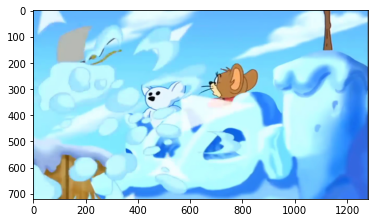

In [99]:
image = ex
import numpy as np
def im_convert(tensor):
    """Display a tensor as an image"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0, 1)
    return image


import matplotlib.pyplot as plt
plt.imshow(im_convert(image))

In [0]:

outputs = model(images)

In [0]:
classes = ( 'happy', 'surprised' , 'angry', 'sad','Unknown')

In [75]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  happy sad sad Unknown


In [101]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network test images: %d %%' % (
    100 * correct / total))

Accuracy of the network test images: 13 %
